In [51]:
import uproot
import awkward as ak
import numpy as np
from coffea import nanoevents
import matplotlib.pyplot as plt


In [12]:
%load_ext autoreload
%autoreload 2

In [16]:
import TaggerInference


In [22]:
nanoevents.PFNanoAODSchema.nested_index_items["FatJetAK15_pFCandsIdxG"] = (
    "FatJetAK15_nConstituents",
    "JetPFCandsAK15",
)
nanoevents.PFNanoAODSchema.mixins["FatJetAK15"] = "FatJet"
nanoevents.PFNanoAODSchema.mixins["FatJetAK15SubJet"] = "FatJet"
nanoevents.PFNanoAODSchema.mixins["SubJet"] = "FatJet"
nanoevents.PFNanoAODSchema.mixins["PFCands"] = "PFCand"
nanoevents.PFNanoAODSchema.mixins["SV"] = "PFCand"


In [17]:
pf_variables = [
    "pfcand_pt_log_nopuppi",
    "pfcand_e_log_nopuppi",
    "pfcand_etarel",
    "pfcand_phirel",
    "pfcand_isEl",
    "pfcand_isMu",
    "pfcand_isGamma",
    "pfcand_isChargedHad",
    "pfcand_isNeutralHad",
    "pfcand_abseta",
    "pfcand_charge",
    "pfcand_VTX_ass",
    "pfcand_lostInnerHits",
    "pfcand_normchi2",
    "pfcand_quality",
    "pfcand_dz",
    "pfcand_dzsig",
    "pfcand_dxy",
    "pfcand_dxysig",
    "pfcand_btagEtaRel",
    "pfcand_btagPtRatio",
    "pfcand_btagPParRatio",
    "pfcand_btagSip3dVal",
    "pfcand_btagSip3dSig",
    "pfcand_btagJetDistVal",
]

sv_variables = [
    "sv_pt_log",
    "sv_mass",
    "sv_etarel",
    "sv_phirel",
    "sv_abseta",
    "sv_ntracks",
    "sv_normchi2",
    "sv_dxy",
    "sv_dxysig",
    "sv_d3d",
    "sv_d3dsig",
    "sv_costhetasvpv",
]


In [6]:
data_dir = "../../../../data/pku_inputs_debug/"

events_dnn = uproot.open(f"{data_dir}/output_numEvent40.root:deepntuplizer/tree").arrays()

fname = f"{data_dir}/nano_skim_0-1.root"
events_coffea = uproot.open(f"{fname}:Events").arrays(library="np")


In [24]:
events_pf = nanoevents.NanoEventsFactory.from_root(
    f"{data_dir}/miniaod_20ul_35914-0.root",
    schemaclass=nanoevents.PFNanoAODSchema,
).events()


/Users/raghav/mambaforge/envs/python310/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (1929 branches) at 0x7fe65984bcd0>, taking first instance
  warnings.warn(
/Users/raghav/mambaforge/envs/python310/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (1929 branches) at 0x7fe65984bcd0>, taking first instance
  warnings.warn(
/Users/raghav/mambaforge/envs/python310/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (1929 branches) at 0x7fe65984bcd0>, taking first instance
  warnings.warn(
/Users/raghav/mambaforge/envs/python310/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nCHadrons in <TTree 'Events' (1929 branches) at 0x7f

In [85]:
pnet_vars = TaggerInference.runInferenceTriton(
    "./tagger_resources/",
    events_pf,
    ak15=False,
    all_outputs=True,
)


Running inference for Jet 1
size of input = 500


100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


Inference took 7.7s
Running inference for Jet 2
size of input = 500


100%|██████████| 2/2 [00:08<00:00,  4.05s/it]

Inference took 8.1s
Total time taken: 16.3s


In [ ]:
tagger_inputs, tagger_outputs, pnet_vars_list = TaggerInference.runInferenceTriton(
    "./tagger_resources/",
    events_pf,
    ak15=False,
    all_outputs=True,
)


In [34]:
npfs = 128
nsvs = 10
idx_pfnano = 7
idx_dnn = 20


def pad_val(array, var_length):
    return (
        ak.pad_none(array, var_length, axis=1, clip=True).to_numpy().filled(fill_value=0)
    ).astype(np.float32)


def get_dnn(branch, idx=idx_dnn):
    if "pfcand" in branch:
        x = pad_val(events_dnn[branch], npfs)
        y = x[idx]
        # y = np.delete(y,28)
        # y = np.append(y,0.)
    elif "sv" in branch:
        y = pad_val(events_dnn[branch], nsvs)[idx]
    else:
        y = events_dnn[branch][idx]
    return y


def get_coffea(branch, idx=idx_pfnano):
    x = events_coffea[branch][idx]
    if "pfcand" in branch:
        sorter = np.copy(events_coffea["pfcand_pt_log_nopuppi"][idx])
        sorter[sorter == 0] = -100
        x = x[ak.argsort(sorter, ascending=False)]

    elif "sv" in branch:
        x = x[ak.argsort(events_coffea["sv_dxysig"][idx], ascending=False)]

    return x


In [174]:
for var in pf_variables:
    x = get_dnn(var)
    y = get_coffea(var)

    if not np.allclose(x, y, rtol=1e-2):
        not_close = np.isclose(x, y, rtol=1e-2) == False
        # print(x[not_close],y[not_close])
        print(var, x[not_close], y[not_close])


pfcand_phirel [-0.00747986 -0.00318325 -0.00660122  0.01332091  0.03255197] [-0.0078125  -0.00341797 -0.00683594  0.01318359  0.03222656]
pfcand_normchi2 [999. 999. 999. 999. 999. 999. 999. 999. 999. 999.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
pfcand_dz [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
pfcand_dzsig [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
pfcand_dxy [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
pfcand_dxysig [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [62]:
for var in sv_variables:
    x = get_dnn(var)
    y = get_coffea(var)

    if not np.allclose(x, y, rtol=1e-2):
        not_close = np.isclose(x, y, rtol=1e-2) == False
        # print(x[not_close],y[not_close])
        print(var, x[not_close], y[not_close])


In [43]:
pf_pt_unc = pad_val((events_pf.FatJet.pt * (1.0 - events_pf.FatJet.rawFactor)), 2)
pf_eta = pad_val(events_pf.FatJet.eta, 2)


(array([25.,  6.,  2.,  6.,  4.,  5.,  3.,  7.,  9., 13.]),
 array([4.77424968e-04, 9.90266949e-02, 1.97575971e-01, 2.96125233e-01,
        3.94674510e-01, 4.93223786e-01, 5.91773033e-01, 6.90322340e-01,
        7.88871586e-01, 8.87420893e-01, 9.85970140e-01]),
 <BarContainer object of 10 artists>)

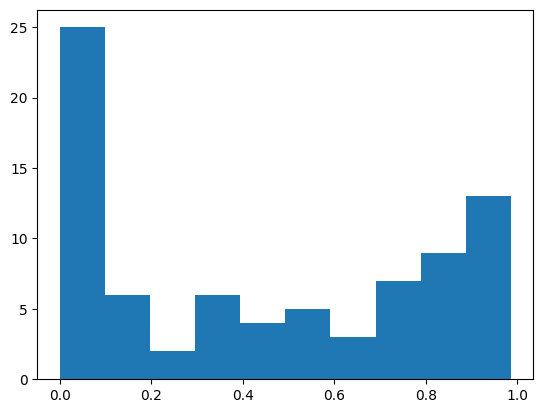

In [56]:
# plt.hist(events_dnn["pfMassDecorrelatedInclParticleTransformerV1JetTags_probHWqqWqq2c"])
plt.hist(
    events_dnn["pfMassDecorrelatedInclParticleTransformerV1DiscriminatorsJetTags_HWW4q3qvsQCD"]
)


(array([178.,  68.,  43.,  56.,  59.,  65.,  77.,  97., 130., 194.]),
 array([4.38614807e-04, 1.00302897e-01, 2.00167179e-01, 3.00031453e-01,
        3.99895728e-01, 4.99760032e-01, 5.99624276e-01, 6.99488580e-01,
        7.99352884e-01, 8.99217129e-01, 9.99081433e-01]),
 <BarContainer object of 10 artists>)

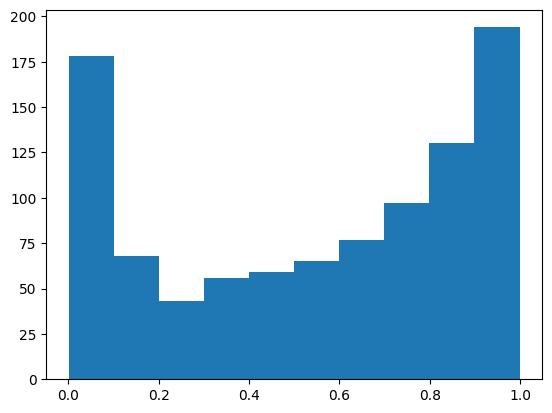

In [87]:
plt.hist(pnet_vars["ak8FatJetParTMD_THWW4q"].reshape(-1))


In [95]:
matches = []
scores = []

for i, (dnn_pt, dnn_eta) in enumerate(zip(events_dnn["fj_pt"], events_dnn["fj_eta"])):
    find_match = np.isclose(dnn_pt, pf_pt_unc, rtol=0.001) * np.isclose(dnn_eta, pf_eta, rtol=0.001)
    if np.any(find_match):
        where = np.where(find_match)
        matches.append([i, [where[0][0], where[1][0]]])
        scores.append(
            [
                events_dnn[
                    "pfMassDecorrelatedInclParticleTransformerV1DiscriminatorsJetTags_HWW4q3qvsQCD"
                ][i],
                pnet_vars["ak8FatJetParTMD_THWW4q"][matches[-1][1][0], matches[-1][1][1]],
            ]
        )

        if not np.isclose(scores[-1][0], scores[-1][1], rtol=0.1):
            print(scores[-1])

scores = np.array(scores)


[0.09782160073518753, 0.1337427]
[0.0580739788711071, 0.052580483]
[0.0922127515077591, 0.081338435]
